<a href="https://colab.research.google.com/github/polesh21/iowa_liquor_sales/blob/stage/EDA_iowa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Connect to Google Bigquery public data "iows_liquor_sales"

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#ensure the file is accessible
!ls /content/gdrive/'My Drive'/'Colab Notebooks'/temp

DPolieshko-0cf48e53ce74.json


In [0]:
from google.cloud import bigquery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/content/gdrive/My Drive/Colab Notebooks/temp/DPolieshko-0cf48e53ce74.json"

In [0]:
#ensure the path is set correctly
!echo $GOOGLE_APPLICATION_CREDENTIALS

/content/gdrive/My Drive/Colab Notebooks/temp/DPolieshko-0cf48e53ce74.json


In [0]:
client = bigquery.Client()

In this analysis we are going to extract data for 2017-2019:


In [0]:
import pandas as pd
import numpy as np

sql = '''
        SELECT *
        FROM `bigquery-public-data.iowa_liquor_sales.sales`
         where date >='2017-01-01' and date <='2019-12-31'
        '''

df = client.query(sql).to_dataframe()

# 2. Data preparation

In [0]:
df[['store_name','county','category_name','vendor_name','item_description','category_name']].describe()
 #   'bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters']].describe()

,store_name,county,category_name,vendor_name,item_description,category_name
count,7027179,6977246,7019110,7027176,7027179,7019110
unique,2007,132,55,250,5303,55
top,Hy-Vee #3 / BDI / Des Moines,POLK,American Vodkas,DIAGEO AMERICAS,Black Velvet,American Vodkas
freq,63906,1160867,1063138,1193449,182819,1063138



Several text columns appear to have not equal number of values. That's why we need to drop na values and remove duplicates in our table

In [0]:
df = df.dropna()
df = df.drop_duplicates()


Now we can identify most frequent values in our columns

In [0]:
df[['store_name','county','category_name','vendor_name','item_description','category_name']].describe()
 #   'bottle_volume_ml','state_bottle_cost','state_bottle_retail','bottles_sold','sale_dollars','volume_sold_liters']].describe()

,store_name,county,category_name,vendor_name,item_description,category_name
count,6315669,6315669,6315669,6315669,6315669,6315669
unique,1863,129,55,243,5090,55
top,Hy-Vee #3 / BDI / Des Moines,POLK,American Vodkas,DIAGEO AMERICAS,Black Velvet,American Vodkas
freq,63770,1032853,958487,1072822,166209,958487


Let's check data types in our table

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6315669 entries, 0 to 7027178
Data columns (total 24 columns):
invoice_and_item_number    object
date                       object
store_number               object
store_name                 object
address                    object
city                       object
zip_code                   object
store_location             object
county_number              object
county                     object
category                   object
category_name              object
vendor_number              object
vendor_name                object
item_number                object
item_description           object
pack                       int64
bottle_volume_ml           int64
state_bottle_cost          float64
state_bottle_retail        float64
bottles_sold               int64
sale_dollars               float64
volume_sold_liters         float64
volume_sold_gallons        float64
dtypes: float64(5), int64(3), object(16)
memory usage: 1.2+ GB


We notice that column with dates isn't actually a date column. Let's fix it

In [0]:
#convert date column to date type
df['date']= pd.to_datetime(df['date'])

#make additional columns for further analysis
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_week_num'] = df['date'].dt.dayofweek
df['day_of_week'] = df['date'].dt.weekday_name
df

,invoice_and_item_number,date,store_number,store_name,address,city,zip_code,store_location,county_number,county,category,category_name,vendor_number,vendor_name,item_number,item_description,pack,bottle_volume_ml,state_bottle_cost,state_bottle_retail,bottles_sold,sale_dollars,volume_sold_liters,volume_sold_gallons,month,year,day_of_week_num,day_of_week
0,INV-22062200070,2019-09-23,2552,Hy-Vee Food Store #3 / Cedar Rapids,20 Wilson Avenue West,Cedar Rapids,52404,POINT (-91.658577 41.955859),57,LINN,1081600,Whiskey Liqueur,121,COOPER SPIRITS INTERNATIONAL,74740,Slow and Low,6,750,12.17,18.26,6,118.56,4.50,1.18,9,2019,0,Monday
1,INV-19241400019,2019-05-08,4609,Kum & Go #579 / Ankeny,165 SW Magazine Rd,Ankeny,50023,POINT (-93.602007 41.717286),77,Polk,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,6,80.82,4.50,1.18,5,2019,2,Wednesday
2,INV-19084500011,2019-05-01,4767,Casey's General Store #3075 / Ankeny,6981 NE 14th St,Ankeny,50023,POINT (-93.600659 41.687793000000006),77,Polk,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,86884,Southern Comfort,24,375,4.78,7.17,12,86.04,4.50,1.18,5,2019,2,Wednesday
3,INV-22554900004,2019-10-15,4980,Pronto BP,7305 Laporte Rd,Washburn,50702,POINT (-92.264665 42.409095),7,Black Hawk,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,6,80.82,4.50,1.18,10,2019,1,Tuesday
4,INV-22243700017,2019-10-01,5519,Casey's General Store #3648 / Akron,80 South St,Akron,51001,POINT (-96.56323 42.823106),75,PLYMOUTH,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,64865,Fireball Cinnamon Whiskey PET,12,750,8.98,13.47,6,80.82,4.50,1.18,10,2019,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027173,INV-10722800103,2018-03-05,2653,Hy-Vee Wine and Spirits / Washington,1004 W Madison St,Washington,52353,POINT (-91.704567 41.296576),92,WASHINGTON,1081600,Whiskey Liqueur,260,DIAGEO AMERICAS,66203,Piehole Apple Pie,12,750,7.49,11.24,2,22.48,1.50,0.40,3,2018,0,Monday
7027174,INV-20525300090,2019-07-10,2605,Hy-Vee Drugstore #5 / Cedar Rapids,2001 Blairs Ferry Road NE,Cedar Rapids,52402,POINT (-91.668909 42.034799),57,LINN,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,66203,Piehole Apple Pie,12,750,7.49,11.24,3,33.72,2.25,0.59,7,2019,2,Wednesday
7027175,INV-21878300041,2019-09-13,2612,Hy-Vee Store / Perry,1215 141 St,Perry,50220,POINT (-94.104501 41.830292),25,DALLAS,1081600,Whiskey Liqueur,421,SAZERAC COMPANY INC,66203,Piehole Apple Pie,12,750,7.49,11.24,3,33.72,2.25,0.59,9,2019,4,Friday
7027176,INV-13091200020,2018-07-06,2602,Hy-Vee Food Store / Webster City,823 2nd St,Webster City,50595,POINT (-93.825486 42.469466),40,HAMILTON,1081600,Whiskey Liqueur,260,DIAGEO AMERICAS,66208,Piehole Cherry Pie,12,750,7.49,11.24,3,33.72,2.25,0.59,7,2018,4,Friday


# 3. Data Analysis

### 3.1. Totals




Let's find annual sold liters amount

In [0]:
by_year = df.groupby(['year']).sum().reset_index()
liters_by_year = by_year[['year','volume_sold_liters']]

#remove scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

liters_by_year

,year,volume_sold_liters
0,2017,18784995.16
1,2018,19959044.48
2,2019,20395769.02


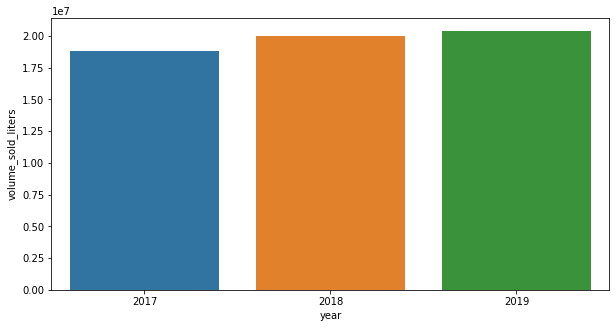

In [0]:
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,5)
sns.barplot(x='year',y='volume_sold_liters',data=liters_by_year)

Sold liters amound slightly tends to grow from year to year

Then we want to find monthly dynamics of volumes sold

In [0]:
by_month = df.groupby(['month']).sum().reset_index()
liters_by_month = by_month[['month','volume_sold_liters']]
liters_by_month

,month,volume_sold_liters
0,1,3992362.34
1,2,4374604.13
2,3,4443313.45
3,4,4718679.60
4,5,5600887.81
5,6,5199680.07
6,7,5025944.05
7,8,5204768.57
8,9,4523443.80
9,10,5612335.03


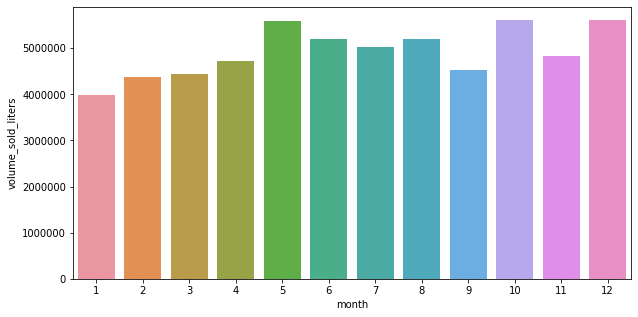

In [0]:
sns.barplot(x='month',y='volume_sold_liters',data=liters_by_month)

May, October and December appears to be the months with highest sold amounts;  January - with lowest

Daily dynamics

In [0]:
by_day = df.groupby(['day_of_week_num','day_of_week']).sum().reset_index()
liters_by_day = by_day[['day_of_week_num','day_of_week','volume_sold_liters']]
liters_by_day

,day_of_week_num,day_of_week,volume_sold_liters
0,0,Monday,12871843.84
1,1,Tuesday,12430716.43
2,2,Wednesday,12815284.63
3,3,Thursday,12667278.59
4,4,Friday,8028630.44
5,5,Saturday,318307.19
6,6,Sunday,7747.54


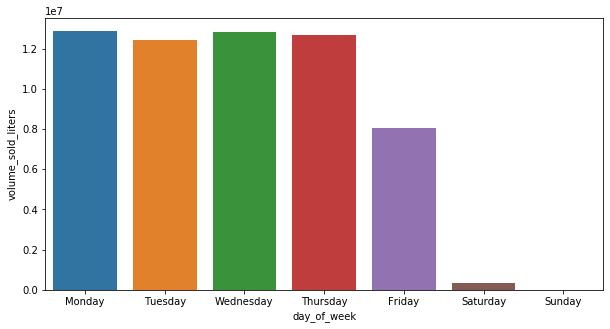

In [0]:
sns.barplot(x='day_of_week',y='volume_sold_liters',data=liters_by_day)

Liquor trade deals are closing mainly on working days. Although, total amounts sold on Friday are 1.5x lower than on any other working day

### 3.2. Cities


Let's find top-10 cities based on total_volume_sold_liters metric


In [0]:
сities_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['city'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

сities_all.columns = ['city', 'total_bottles_sold','total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']

сities_all = сities_all.sort_values(by='total_volume_sold_liters', ascending = False)
сities_all['perc_volume_sold_liters'] = сities_all['total_volume_sold_liters']/сities_all['total_volume_sold_liters'].sum()
сities_all['cum_perc_volume_sold_liters'] = сities_all['perc_volume_sold_liters'].cumsum()

сities_all.head(10)

,city,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_volume_sold_liters,cum_perc_volume_sold_liters
103,Des Moines,9298489,120228325.14,10.62,15.93,6944199.47,0.12,0.12
58,Cedar Rapids,5081923,63669053.52,9.96,14.94,4140881.71,0.07,0.19
93,Davenport,3581472,40591145.58,9.54,14.31,2601383.49,0.04,0.23
410,West Des Moines,2196995,34661601.47,11.03,16.54,2134629.79,0.04,0.27
351,Sioux City,2556953,33318306.35,10.32,15.48,2103556.77,0.04,0.30
85,Council Bluffs,2533833,31864398.02,9.62,14.43,2017998.46,0.03,0.34
399,Waterloo,2870304,30859116.41,9.10,13.65,1883899.08,0.03,0.37
192,Iowa City,2180106,29804335.09,10.48,15.72,1866179.87,0.03,0.40
108,Dubuque,1667467,22370781.81,10.30,15.45,1464046.66,0.02,0.43
16,Ames,1471988,21400066.30,11.40,17.10,1445232.05,0.02,0.45


Des Moines has 12% of all volume sold in Iowa; 45% of all liquor volume sold in Iowa were sold in top-10 cities

Find more interesting numbers about cities

In [0]:
print('50% of all liquor volume sold in Iowa were sold in ' + (round(сities_all[сities_all['cum_perc_volume_sold_liters']<=0.5].city.count() / сities_all.city.count(),2)*100).astype(int).astype(str) + '% cities')

50% of all liquor volume sold in Iowa were sold in 3% cities


In [0]:
print('75% of all liquor volume sold in Iowa were sold in ' + (round(сities_all[сities_all['cum_perc_volume_sold_liters']<=0.75].city.count() / сities_all.city.count(),2)*100).astype(int).astype(str) + '% cities')

75% of all liquor volume sold in Iowa were sold in 10% cities


For better understanding let's visualize all volumes by city using a treemap and label first top-20 cities

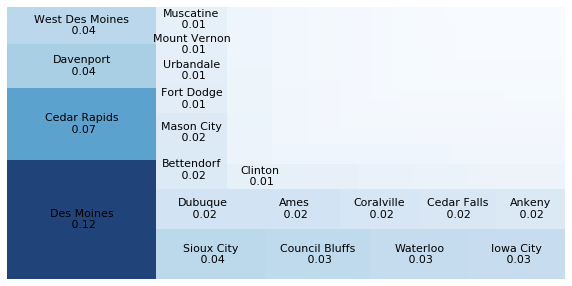

In [0]:
#disable chained_assignment warning
pd.options.mode.chained_assignment = None

top_cities_df = сities_all.head(20)
top_cities_df['label'] = top_cities_df['city'] + "\n " + top_cities_df['perc_volume_sold_liters'].round(2).astype(str)
top_cities = top_cities_df['label'].tolist()

#using squarify
!pip install -q squarify
import squarify    
import matplotlib as mpl

# create a color palette, mapped to these values
cmap = mpl.cm.Blues
mini=сities_all['perc_volume_sold_liters'].min()
maxi=сities_all['perc_volume_sold_liters'].max()
norm = mpl.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in сities_all['perc_volume_sold_liters']]

squarify.plot(sizes=сities_all['perc_volume_sold_liters'], label=top_cities, alpha=.9, color=colors)
plt.rc('font', size=10)
plt.axis('off')
plt.show()

### Stores

 Find top-10 stores based on total_sale_dollars metric

In [0]:
stores_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['store_number','store_name'],
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()
stores_all                            

,store_number,store_name,bottles_sold,sale_dollars,state_bottle_cost,state_bottle_retail,volume_sold_liters
0,2106,Hillstreet News and Tobacco,270606,3843546.60,11.19,16.79,253391.77
1,2113,Jamboree Foods,17406,242749.21,11.12,16.68,17119.30
2,2130,Sycamore Convenience,221483,3477916.42,11.39,17.09,202344.55
3,2178,Double D Liquor Store,64756,943689.35,10.55,15.83,68996.44
4,2190,Central City Liquor Inc.,368300,5412035.38,14.19,21.29,235864.39
...,...,...,...,...,...,...,...
1887,9930,Thome Enterprises LLC,3,144.00,8.00,12.00,2.25
1888,9931,Lonely Oak Distilery,44,2520.00,14.00,21.00,33.00
1889,9934,Cats Eye Distillery LLC,2,693.12,19.25,28.88,1.50
1890,9937,Green Frog Distillery LLC,2,157.50,17.50,26.25,1.50


It seems that store names could be duplicated because of double quotes in their names in different order. That's why let's replace all double quotes and re-create stores_all table


In [0]:
df['store_name'] = df['store_name'].str.replace('"', '', regex=False)
stores_all_clean = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['store_number','store_name','city'],
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

Check duplicates in stores_all table

In [0]:
check_stores = stores_all_clean.groupby(['store_number']).size().reset_index()
check_stores = check_stores.rename(columns={0:"count"})
check_stores[check_stores['count']>1].count()

store_number    97
count           97
dtype: int64

We still have duplicated names in stores_all table. To save the time (trying to clean all city names) and get the correct amount for every city let's create pivot table grouping by "store_number" and then join one of store's names for every 97 stores from the previous conclusion


In [0]:
stores_all_clean = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['store_number'],
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

stores_dict = df[['store_number','store_name','city']]
stores_dict = stores_dict.groupby('store_number').first().reset_index()

stores_all_clean_merged = stores_all_clean.merge(stores_dict, how = 'left', on = 'store_number')

So, now we can find top-10 stores based on total_sale_dollars metric

In [0]:
stores_all_final = stores_all_clean_merged[['store_number','store_name','city','bottles_sold','sale_dollars','state_bottle_cost','state_bottle_retail','volume_sold_liters']]

stores_all_final.columns = ['store_number', 'store_name','city', 'total_bottles_sold', 'total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']

stores_all_final = stores_all_final.sort_values(by='total_sale_dollars', ascending = False)
stores_all_final['perc_sale_dollars'] = stores_all_final['total_sale_dollars']/сities_all['total_sale_dollars'].sum()
stores_all_final['cum_perc_sale_dollars'] = stores_all_final['perc_sale_dollars'].cumsum()

stores_all_final.head(10)

,store_number,store_name,city,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_sale_dollars,cum_perc_sale_dollars
101,2633,Hy-Vee #3 / BDI / Des Moines,Des Moines,1938638,32901149.78,13.29,19.93,1872405.67,0.04,0.04
871,4829,Central City 2,Des Moines,1863670,32526634.79,13.28,19.92,1790455.22,0.04,0.07
24,2512,Hy-Vee Wine and Spirits / Iowa City,Iowa City,976151,14284859.36,11.91,17.87,927920.85,0.02,0.09
179,3385,Sams Club 8162 / Cedar Rapids,Cedar Rapids,598008,10106219.49,12.94,19.42,703010.75,0.01,0.10
1062,5102,Wilkie Liquors,Mount Vernon,672105,9915269.30,12.32,18.49,662532.06,0.01,0.11
286,3814,Costco Wholesale #788,West Des Moines,422966,9468382.97,22.19,33.29,659244.50,0.01,0.12
340,3952,Lot-A-Spirits,Bettendorf,526827,9173915.26,13.57,20.36,506824.15,0.01,0.13
271,3773,Benz Distributing,Cedar Rapids,485705,8500602.81,14.75,22.12,462885.11,0.01,0.14
122,2663,Hy-Vee Food Store / Urbandale,Urbandale,465286,8386969.53,12.25,18.37,414637.66,0.01,0.15
128,2670,Hy-Vee Food Store / Coralville,Coralville,499912,8206162.41,11.21,16.82,476546.94,0.01,0.16


Find more interesting numbers about stores

In [0]:
print('33% of all total_sale_dollars were paid by ' + (round(stores_all_final[stores_all_final['cum_perc_sale_dollars']<=0.33].store_name.count() / stores_all_final.store_name.count(),2)*100).astype(int).astype(str) + '% stores')

33% of all total_sale_dollars were paid by 2% stores


In [0]:
print('50% of all total_sale_dollars were paid by ' + (round(stores_all_final[stores_all_final['cum_perc_sale_dollars']<=0.5].store_name.count() / stores_all_final.store_name.count(),2)*100).astype(int).astype(str) + '% stores')

50% of all total_sale_dollars were paid by 5% stores


### 3.3. Categories

Find top-10 categories based on total_sale_dollars and total_volume_sold_liters metrics


In [0]:
categories_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['category_name'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

categories_all.columns = ['category_name', 'total_bottles_sold','total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']

categories_all_by_volume = categories_all.sort_values(by='total_volume_sold_liters', ascending = False)
categories_all_by_sale_dollars = categories_all.sort_values(by='total_sale_dollars', ascending = False)

categories_all_by_volume['perc_volume_sold_liters'] = categories_all_by_volume['total_volume_sold_liters']/categories_all_by_volume['total_volume_sold_liters'].sum()
categories_all_by_volume['cum_perc_volume_sold_liters'] = categories_all_by_volume['perc_volume_sold_liters'].cumsum()

categories_all_by_sale_dollars['perc_sale_dollars'] = categories_all_by_sale_dollars['total_sale_dollars']/categories_all_by_sale_dollars['total_sale_dollars'].sum()
categories_all_by_sale_dollars['cum_perc_sale_dollars'] = categories_all_by_sale_dollars['perc_sale_dollars'].cumsum()

categories_all_by_volume.head(10)

,category_name,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_volume_sold_liters,cum_perc_volume_sold_liters
12,American Vodkas,14659144,131707640.10,6.56,9.85,13645659.66,0.23,0.23
15,Canadian Whiskies,7701801,112390761.50,10.08,15.12,7776893.14,0.13,0.36
46,Spiced Rum,3926716,59711818.24,9.43,14.15,3867088.57,0.07,0.43
53,Whiskey Liqueur,5048750,47231044.82,12.46,18.69,2749294.08,0.05,0.47
47,Straight Bourbon Whiskies,3139279,58285138.10,12.46,18.68,2730561.93,0.05,0.52
34,Imported Vodkas,2450254,45668133.71,12.72,19.09,2448321.10,0.04,0.56
13,Blended Whiskies,2399283,23705287.88,7.58,11.37,2207990.76,0.04,0.60
17,Cocktails /RTD,1299615,14472983.92,7.62,11.44,2051252.93,0.03,0.63
8,American Flavored Vodka,2419804,24489463.54,7.11,10.67,1783932.26,0.03,0.66
54,White Rum,1580357,17690824.46,7.49,11.24,1694835.34,0.03,0.69


In [0]:
categories_all_by_sale_dollars.head(10)

,category_name,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_sale_dollars,cum_perc_sale_dollars
12,American Vodkas,14659144,131707640.10,6.56,9.85,13645659.66,0.15,0.15
15,Canadian Whiskies,7701801,112390761.50,10.08,15.12,7776893.14,0.12,0.27
46,Spiced Rum,3926716,59711818.24,9.43,14.15,3867088.57,0.07,0.34
47,Straight Bourbon Whiskies,3139279,58285138.10,12.46,18.68,2730561.93,0.06,0.40
53,Whiskey Liqueur,5048750,47231044.82,12.46,18.69,2749294.08,0.05,0.45
34,Imported Vodkas,2450254,45668133.71,12.72,19.09,2448321.10,0.05,0.50
51,Tennessee Whiskies,1686991,38727650.31,14.33,21.49,1318084.41,0.04,0.55
0,100% Agave Tequila,1208641,31501897.00,18.54,27.81,893541.53,0.03,0.58
25,Imported Brandies,1668459,29421448.08,15.45,23.17,686258.53,0.03,0.61
8,American Flavored Vodka,2419804,24489463.54,7.11,10.67,1783932.26,0.03,0.64


We notice that Vodkas and Whiskies are categories with the highest amount both volume_sold and sale_dollars. For better undertanding the interdependencies between these categories let's make several aggregated groups.


In [0]:
categories_all['agg_category'] = np.where(categories_all['category_name'].str.lower().str.contains('whisk'), 'Whiskies', 
                                          np.where(categories_all['category_name'].str.lower().str.contains('vodka'), 'Vodkas', 
                                                   np.where(categories_all['category_name'].str.lower().str.contains('gin'), 'Gins',
                                                            np.where(categories_all['category_name'].str.lower().str.contains('rum'), 'Rums',
                                                                                                                                  'Others'))))

In [0]:
categories_agg = pd.pivot_table(categories_all, values=['total_bottles_sold','total_sale_dollars','total_volume_sold_liters','average_bottle_cost','average_state_bottle_retail'], index=['agg_category'], 
                            aggfunc={'total_bottles_sold':np.sum, 'total_sale_dollars':np.sum, 'total_volume_sold_liters':np.sum, 'average_bottle_cost':np.mean, 'average_state_bottle_retail':np.mean}).reset_index()
categories_agg                           

,agg_category,average_bottle_cost,average_state_bottle_retail,total_bottles_sold,total_sale_dollars,total_volume_sold_liters
0,Gins,8.55,12.83,1795653,21913799.61,1503611.97
1,Others,13.45,20.18,17720863,235584996.87,13341754.14
2,Rums,9.24,13.87,7249021,100887306.29,7192307.33
3,Vodkas,10.35,15.53,20587290,220286589.03,18703496.66
4,Whiskies,15.68,23.52,21706275,324448702.41,18398638.56


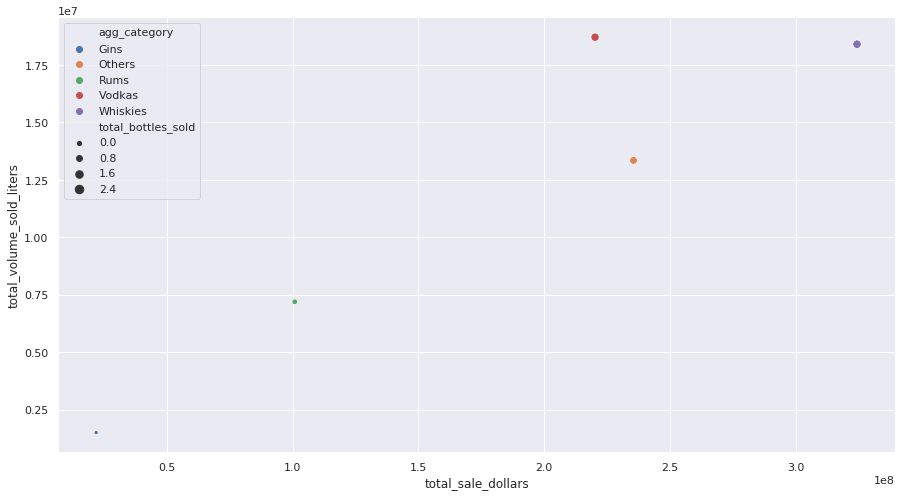

In [0]:
import seaborn as sns; sns.set()

ax = sns.scatterplot(x="total_sale_dollars", y="total_volume_sold_liters", data=categories_agg, hue = 'agg_category', size="total_bottles_sold")
sns.set(rc={'figure.figsize':(15,8)})

As we see from the chart, Vodkas and Whiskies indeed are the best selling liquors in Iowa. Despite the nearly equal total_volume_sold and total_bottles_sold, total_sale_dollars, average Whiskies price per liter is nearly 1.5x higher than Vodkas.

### 3.4. Vendors


In [0]:
vendors_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['vendor_name'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

vendors_all.columns = ['vendor_name', 'total_bottles_sold','total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']


vendors_all

,vendor_name,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters
0,10th Mountain Whiskey & Spirit Company,6,292.50,32.50,48.75,4.50
1,3 BADGE CORPORATION,1812,50834.73,19.45,29.17,1359.00
2,"3-Oaks Distillery, LLC",671,19814.40,18.02,27.03,503.25
3,A HARDY USA LTD,1041,18347.91,11.13,16.69,780.75
4,A V BRANDS INC,30,815.82,20.21,30.32,22.50
...,...,...,...,...,...,...
238,William Grant & Sons Inc,345708,8415582.47,18.70,28.06,291586.66
239,Winebow Inc,12,195.12,10.84,16.26,9.00
240,World Trade Liquor Imports LLC,24,1503.00,41.75,62.62,18.00
241,"Worldwide Libations, LLC",2297,51382.44,14.91,22.36,1722.75


Top-10 vendors based on total_sale_dollars and total_volume_sold_liters metrics

In [0]:
vendors_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['vendor_name'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

vendors_all.columns = ['category_name', 'total_bottles_sold','total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']

vendors_all_by_sale_dollars = vendors_all.sort_values(by='total_sale_dollars', ascending = False)
vendors_all_by_sale_dollars['perc_sale_dollars'] = vendors_all_by_sale_dollars['total_sale_dollars']/vendors_all_by_sale_dollars['total_sale_dollars'].sum()
vendors_all_by_sale_dollars['cum_perc_sale_dollars'] = vendors_all_by_sale_dollars['perc_sale_dollars'].cumsum()

vendors_all_by_sale_dollars.head(10)

,category_name,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_sale_dollars,cum_perc_sale_dollars
46,DIAGEO AMERICAS,10523049,193087776.92,12.46,18.70,9206446.02,0.21,0.21
183,SAZERAC COMPANY INC,8800965,76561034.22,11.06,16.59,5561309.23,0.08,0.30
102,Jim Beam Brands,4759446,68387812.08,9.86,14.79,4354502.69,0.08,0.37
155,PERNOD RICARD USA,3715227,66099956.26,12.21,18.32,3000800.41,0.07,0.45
31,CONSTELLATION BRANDS INC,5344306,54832948.07,7.05,10.58,5209043.69,0.06,0.51
111,LUXCO INC,6034334,47950829.08,5.85,8.78,6204915.07,0.05,0.56
27,Brown Forman Corp.,2037932,46888290.57,14.51,21.76,1649160.25,0.05,0.61
63,FIFTH GENERATION INC,2122600,39912885.84,12.23,18.35,2207103.54,0.04,0.66
13,BACARDI USA INC,2063968,35802302.44,12.13,18.19,1854859.52,0.04,0.70
184,SAZERAC NORTH AMERICA,3817805,29579768.11,6.06,9.08,4134035.51,0.03,0.73


In [0]:
vendors_all_by_volume = vendors_all.sort_values(by='total_volume_sold_liters', ascending = False)

vendors_all_by_volume['perc_volume_sold_liters'] = vendors_all_by_volume['total_volume_sold_liters']/categories_all_by_volume['total_volume_sold_liters'].sum()
vendors_all_by_volume['cum_perc_volume_sold_liters'] = vendors_all_by_volume['perc_volume_sold_liters'].cumsum()

vendors_all_by_volume.head(10)

,category_name,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_volume_sold_liters,cum_perc_volume_sold_liters
46,DIAGEO AMERICAS,10523049,193087776.92,12.46,18.70,9206446.02,0.16,0.16
111,LUXCO INC,6034334,47950829.08,5.85,8.78,6204915.07,0.10,0.26
183,SAZERAC COMPANY INC,8800965,76561034.22,11.06,16.59,5561309.23,0.09,0.35
31,CONSTELLATION BRANDS INC,5344306,54832948.07,7.05,10.58,5209043.69,0.09,0.44
102,Jim Beam Brands,4759446,68387812.08,9.86,14.79,4354502.69,0.07,0.52
184,SAZERAC NORTH AMERICA,3817805,29579768.11,6.06,9.08,4134035.51,0.07,0.59
155,PERNOD RICARD USA,3715227,66099956.26,12.21,18.32,3000800.41,0.05,0.64
63,FIFTH GENERATION INC,2122600,39912885.84,12.23,18.35,2207103.54,0.04,0.67
87,Heaven Hill Brands,2344656,25616129.58,7.75,11.63,2169508.61,0.04,0.71
112,Laird & Company,2424523,13742628.41,4.61,6.91,2051218.10,0.03,0.75


DIAGEO AMERICAS	- top vendor by both metrics - have near 1/5 of all Iowa money spent on liquor and near 1/6 of all liters sold in Iowa were DIAGEO AMERICAS liquors

Let's find the most popular bottle_volume for every vendor


In [0]:
vendors_all_with_bottle_volume = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['vendor_name','bottle_volume_ml'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()
                            
bottle_volumes = vendors_all_with_bottle_volume[['vendor_name','bottle_volume_ml','bottles_sold']].sort_values(['vendor_name','bottles_sold'], ascending=False)
bottle_volumes_grouped = bottle_volumes.groupby(['vendor_name']).head(1)
bottle_volumes_grouped = bottle_volumes_grouped.groupby('bottle_volume_ml').size().reset_index()
bottle_volumes_grouped = bottle_volumes_grouped.rename(columns={0:'count_by_vendor'})
print("bottle volume 750 ml is the most popular volume among "+ (round(bottle_volumes_grouped[bottle_volumes_grouped['bottle_volume_ml']==750].count_by_vendor.sum() / bottle_volumes_grouped.count_by_vendor.sum(),2)*100).astype(int).astype(str) + "% vendors")

bottle volume 750 ml is the most popular volume among 86% vendors


### 3.5. Products

Find top-10 products by total_volume_sold_liters metrics

In [0]:
products_all = pd.pivot_table(df, values=['bottles_sold','state_bottle_cost','state_bottle_retail','sale_dollars','volume_sold_liters'], index=['item_description', 'vendor_name'], 
                            aggfunc={'bottles_sold':np.sum, 'state_bottle_cost':np.mean, 'state_bottle_retail':np.mean, 'sale_dollars':np.sum, 'volume_sold_liters':np.sum}).reset_index()

products_all.columns = ['item_description', 'vendor_name', 'total_bottles_sold','total_sale_dollars', 'average_bottle_cost','average_state_bottle_retail','total_volume_sold_liters']

products_all = products_all.sort_values(by='total_volume_sold_liters', ascending = False)
products_all['perc_volume_sold_liters'] = products_all['total_volume_sold_liters']/products_all['total_volume_sold_liters'].sum()
products_all['cum_perc_volume_sold_liters'] = products_all['perc_volume_sold_liters'].cumsum()

products_all.head(10)

,item_description,vendor_name,total_bottles_sold,total_sale_dollars,average_bottle_cost,average_state_bottle_retail,total_volume_sold_liters,perc_volume_sold_liters,cum_perc_volume_sold_liters
609,Black Velvet,CONSTELLATION BRANDS INC,3147688,33791604.96,6.74,10.11,3594744.51,0.06,0.06
2466,Hawkeye Vodka,LUXCO INC,2328195,15371444.41,4.71,7.07,2411879.59,0.04,0.10
4898,Titos Handmade Vodka,FIFTH GENERATION INC,2098566,39446795.28,12.19,18.28,2196830.19,0.04,0.14
1006,Captain Morgan Spiced Rum,DIAGEO AMERICAS,1344476,23445541.91,11.48,17.23,1375028.58,0.02,0.16
1911,Fireball Cinnamon Whiskey,SAZERAC COMPANY INC,1815526,19656869.05,9.76,14.65,1223309.50,0.02,0.18
492,Barton Vodka,SAZERAC NORTH AMERICA,1021632,6848300.77,5.13,7.70,1141185.05,0.02,0.20
1943,Five O'clock Vodka,Laird & Company,907575,5369980.16,4.83,7.25,826037.51,0.01,0.22
3344,Mccormick Vodka Pet,McCormick Distilling Co.,1193381,4784123.69,4.14,6.22,699275.63,0.01,0.23
172,Admiral Nelson Spiced Rum,Heaven Hill Brands,645203,7210094.93,8.03,12.05,692306.25,0.01,0.24
1347,Crown Royal,DIAGEO AMERICAS,805478,19130260.57,15.36,23.05,638672.21,0.01,0.25
